# Demo: Training and testing with synthetic data

## Installing libraries using pip

In [27]:
pip install sdv pandas plotly.express scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Loading real dataset

In [29]:
# Load our real dataset and explore its characteristics.
import pandas as pd

# Load the dataset
# Note: this dataset is intentionally very simple for demonstration purposes
# A real dataset would be more nuanced
data = pd.read_csv('creditcard.csv')
data.head()

# View the dataset structure:
print(data[['Amount', 'Class']].head())

data['Class'].value_counts()

   Amount  Class
0  202.09      0
1   50.06      0
2  134.02      0
3   28.89      0
4   47.78      0


Class
0    494
1      6
Name: count, dtype: int64

## Generate Synthetic Data

In [31]:
# Use SingleTableMetadata to define the structure of the dataset
# There are other metadata classes available, but SingleTableMetadata is suitable for single table datasets.
from sdv.single_table import GaussianCopulaSynthesizer 
from sdv.metadata import SingleTableMetadata 

# Load fraudulent and non-fraudulent transactions
fraudulent_data = data[data['Class'] == 1].copy()
non_fraudulent_data = data[data['Class'] == 0].copy()

# Create metadata specifically for the fraudulent data
fraud_metadata = SingleTableMetadata()
fraud_metadata.detect_from_dataframe(fraudulent_data)
fraud_metadata.set_primary_key(column_name='Transaction ID')

# Initialize and fit the synthesizer on fraudulent data
fraud_synthesizer = GaussianCopulaSynthesizer(fraud_metadata)
fraud_synthesizer.fit(fraudulent_data)
print("Synthesizer fitted to fraudulent data.")

# Generate synthetic fraudulent transactions (using 50 as an example)
num_synthetic_fraud = 50
synthetic_fraud_data = fraud_synthesizer.sample(num_rows=num_synthetic_fraud)

print(f"Generated {len(synthetic_fraud_data)} synthetic fraudulent transactions.")
synthetic_fraud_data.head()

Synthesizer fitted to fraudulent data.
Generated 50 synthetic fraudulent transactions.


,Date,Description,Amount,Category,Transaction ID,Class
0,2024-07-03,Book Store,442.62,Apparel,13361360,1
1,2024-04-15,Online Shop,1157.19,Shopping,3321222,1
2,2024-04-15,Cafe Perk,475.25,Coffee,15699584,1
3,2024-04-15,Cafe Perk,681.84,Coffee,3722248,1
4,2024-04-15,Cafe Perk,1223.65,Coffee,13050632,1


## Combine Real and Synthetic Data

In [33]:
import pandas as pd
import numpy as np

# ============= Combining Data for Augmentation =============
# This section creates the 'augmented_data' by combining all parts of your dataset:
# original non-fraudulent transactions, original fraudulent transactions,
# and the newly generated synthetic fraudulent transactions.
# .reset_index(drop=True) ensures a clean, continuous index for the new DataFrame.

augmented_data = pd.concat([non_fraudulent_data, fraudulent_data, synthetic_fraud_data]).reset_index(drop=True)

def get_dataset_counts(df, dataset_name):
    class_counts = df['Class'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    class_counts['Dataset'] = dataset_name
    return class_counts

original_plot_data = get_dataset_counts(data, 'Original')
augmented_plot_data = get_dataset_counts(augmented_data, 'Augmented')

combined_for_plot = pd.concat([original_plot_data, augmented_plot_data])

# --- Filter to show ONLY Fraudulent Data ---
# Ensure 'Class' column is string before filtering if it contains mixed types from value_counts
combined_for_plot['Class'] = combined_for_plot['Class'].astype(str)
combined_for_plot_filtered = combined_for_plot[combined_for_plot['Class'] == '1'].copy() # Filter for string '1'

# --- Map Class labels to 'Non-Fraudulent' and 'Fraudulent' ---
# Apply mapping *after* filtering so 'Total' doesn't interfere
combined_for_plot_filtered['Class'] = combined_for_plot_filtered['Class'].replace({
    '0': 'Non-Fraudulent', # Will not be present after filtering but good for robustness
    '1': 'Fraudulent'
})



## Showing Data Pools

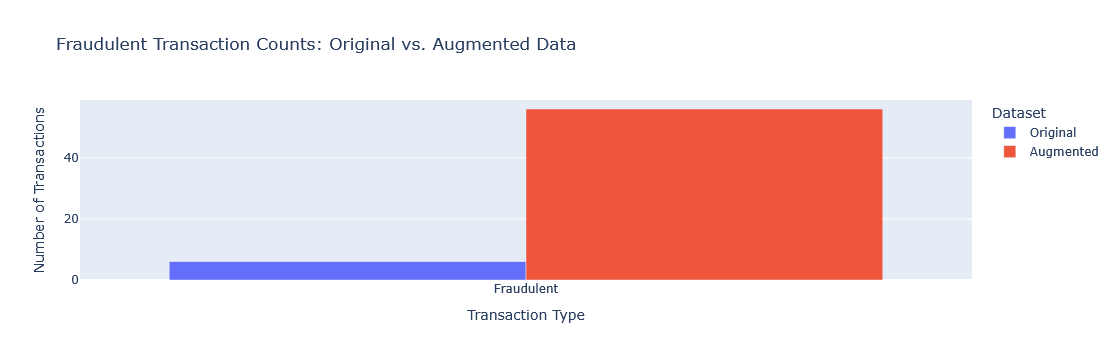

In [35]:
import plotly.express as px

# Define the order for x-axis categories (only Fraudulent now)
category_order = ['Fraudulent']

# --- Create the Bar Chart ---
fig_bar = px.bar(
    combined_for_plot_filtered, # Use the filtered DataFrame
    x='Class',
    y='Count',
    color='Dataset',
    barmode='group',
    title='Fraudulent Transaction Counts: Original vs. Augmented Data',
    labels={
        'Class': 'Transaction Type',
        'Count': 'Number of Transactions'
    },
    category_orders={"Class": category_order}
)

fig_bar.show()

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- 1. Prepare Features (X) and Target (y) ---
y = augmented_data['Class']
features = augmented_data[['Amount', 'Category']]
X = pd.get_dummies(features, columns=['Category'], drop_first=True)

# --- 2. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# --- 3. Train the Model ---
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# --- 4. Make Predictions ---
y_pred = model.predict(X_test)

# --- 5. Evaluate Model Performance ---
accuracy = model.score(X_test, y_test) * 100
print(f"\nModel Accuracy: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 97.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       148
           1       0.93      0.82      0.88        17

    accuracy                           0.98       165
   macro avg       0.96      0.91      0.93       165
weighted avg       0.98      0.98      0.98       165



In [39]:
print(augmented_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            550 non-null    object 
 1   Description     550 non-null    object 
 2   Amount          550 non-null    float64
 3   Category        550 non-null    object 
 4   Transaction ID  550 non-null    int64  
 5   Class           550 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 25.9+ KB
None


In [ ]:
# Separate data by the 'Class'
non_fraud = augmented_data[augmented_data['Class'] == 0]
fraud = augmented_data[augmented_data['Class'] == 1]

print("--- Stats for Non-Fraudulent Transactions ---")
print(non_fraud['Amount'].describe())

print("\n--- Stats for Fraudulent Transactions ---")
print(fraud['Amount'].describe())
